In [16]:
from tqdm.notebook import tqdm

#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Dlnpyutils
from dlnpyutils import utils
from dlnpyutils.utils import bspline

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

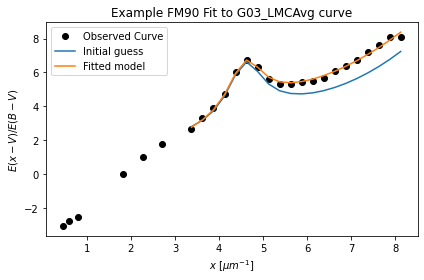

In [2]:
import warnings
# import matplotlib.pyplot as plt
# import numpy as np

from astropy.modeling.fitting import LevMarLSQFitter
import astropy.units as u

from dust_extinction.averages import G03_LMCAvg
from dust_extinction.shapes import FM90

# get an observed extinction curve to fit
g03_model = G03_LMCAvg()

x = g03_model.obsdata_x / u.micron
# convert to E(x-V)/E(B0V)
y = (g03_model.obsdata_axav - 1.0) * g03_model.Rv
# only fit the UV portion (FM90 only valid in UV)
(gindxs,) = np.where(x > 3.125 / u.micron)

# initialize the model
fm90_init = FM90()

# pick the fitter
fit = LevMarLSQFitter()

# fit the data to the FM90 model using the fitter
#   use the initialized model as the starting point

# ignore some warnings
#   UserWarning is to avoid the units of x warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    g03_fit = fit(fm90_init, x[gindxs].value, y[gindxs])

# plot the observed data, initial guess, and final fit
fig, ax = plt.subplots()

ax.plot(x, y, "ko", label="Observed Curve")
ax.plot(x[gindxs], fm90_init(x[gindxs]), label="Initial guess")
ax.plot(x[gindxs], g03_fit(x[gindxs]), label="Fitted model")

ax.set_xlabel("$x$ [$\mu m^{-1}$]")
ax.set_ylabel("$E(x-V)/E(B-V)$")

ax.set_title("Example FM90 Fit to G03_LMCAvg curve")

ax.legend(loc="best")
plt.tight_layout()
plt.show()

In [3]:
from dust_extinction.parameter_averages import F99

# define the model
ext = F99(Rv=3.1)

In [5]:
ext.extinguish(0.441, Ebv=0.5)

/opt/anaconda3/lib/python3.8/site-packages/dust_extinction/helpers.py:31: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(


0.8605996338619537

In [6]:
help(ext.extinguish)

Help on method extinguish in module dust_extinction.baseclasses:

extinguish(x, Av=None, Ebv=None) method of dust_extinction.parameter_averages.F99 instance
    Calculate the extinction as a fraction
    
    Parameters
    ----------
    x: float
       expects either x in units of wavelengths or frequency
       or assumes wavelengths in wavenumbers [1/micron]
    
       internally wavenumbers are used
    
    Av: float
       A(V) value of dust column
       Av or Ebv must be set
    
    Ebv: float
       E(B-V) value of dust column
       Av or Ebv must be set
    
    Returns
    -------
    frac_ext: np array (float)
       fractional extinction as a function of x



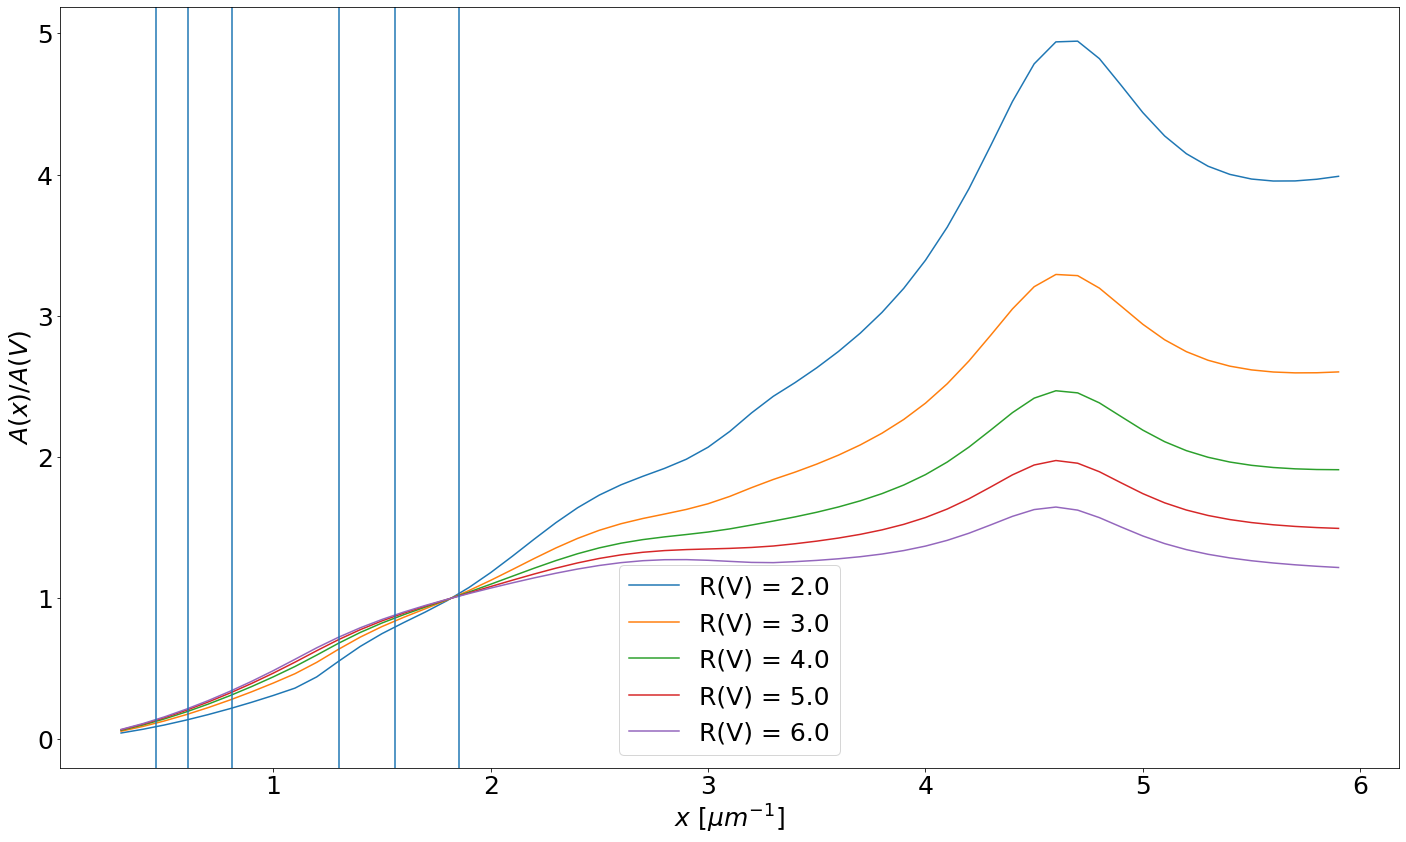

In [46]:
from dust_extinction.parameter_averages import CCM89

fig, ax = plt.subplots(figsize=[24,14])

# generate the curves and plot them
x = np.arange(0.3,6.0,0.1)/u.micron

Rvs = ['2.0','3.0','4.0','5.0','6.0']
for cur_Rv in Rvs:
    ext_model = CCM89(Rv=cur_Rv)
    ax.plot(x,ext_model(x),label='R(V) = ' + str(cur_Rv))
    
for recip_wave in np.reciprocal(leff):
    plt.axvline(recip_wave)

ax.set_xlabel(r'$x$ [$\mu m^{-1}$]')
ax.set_ylabel(r'$A(x)/A(V)$')

ax.legend(loc='best')
plt.show()

In [8]:
ext_model(0.551)

0.18622554455105414

In [29]:
leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757])

In [43]:
ext_model = CCM89(Rv=3.1)
ext_model(1/(leff*u.micron))

array([1.02330779, 0.84000359, 0.64685287, 0.28779332, 0.18229774,
       0.11557049])

In [32]:
ccm_alav_coeff = 999999.0*np.ones(len(leff))
for i in range(len(leff)):
    ccm_alav_coeff[i] = ccm_alav(leff[i],3.1)

In [44]:
ccm_alav_coeff

array([1.0233074 , 0.83998298, 0.64677309, 0.28779332, 0.18229774,
       0.11557049])

In [40]:
1/np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757])

array([1.85632077, 1.55787506, 1.30429112, 0.81004455, 0.61001647,
       0.45962219])

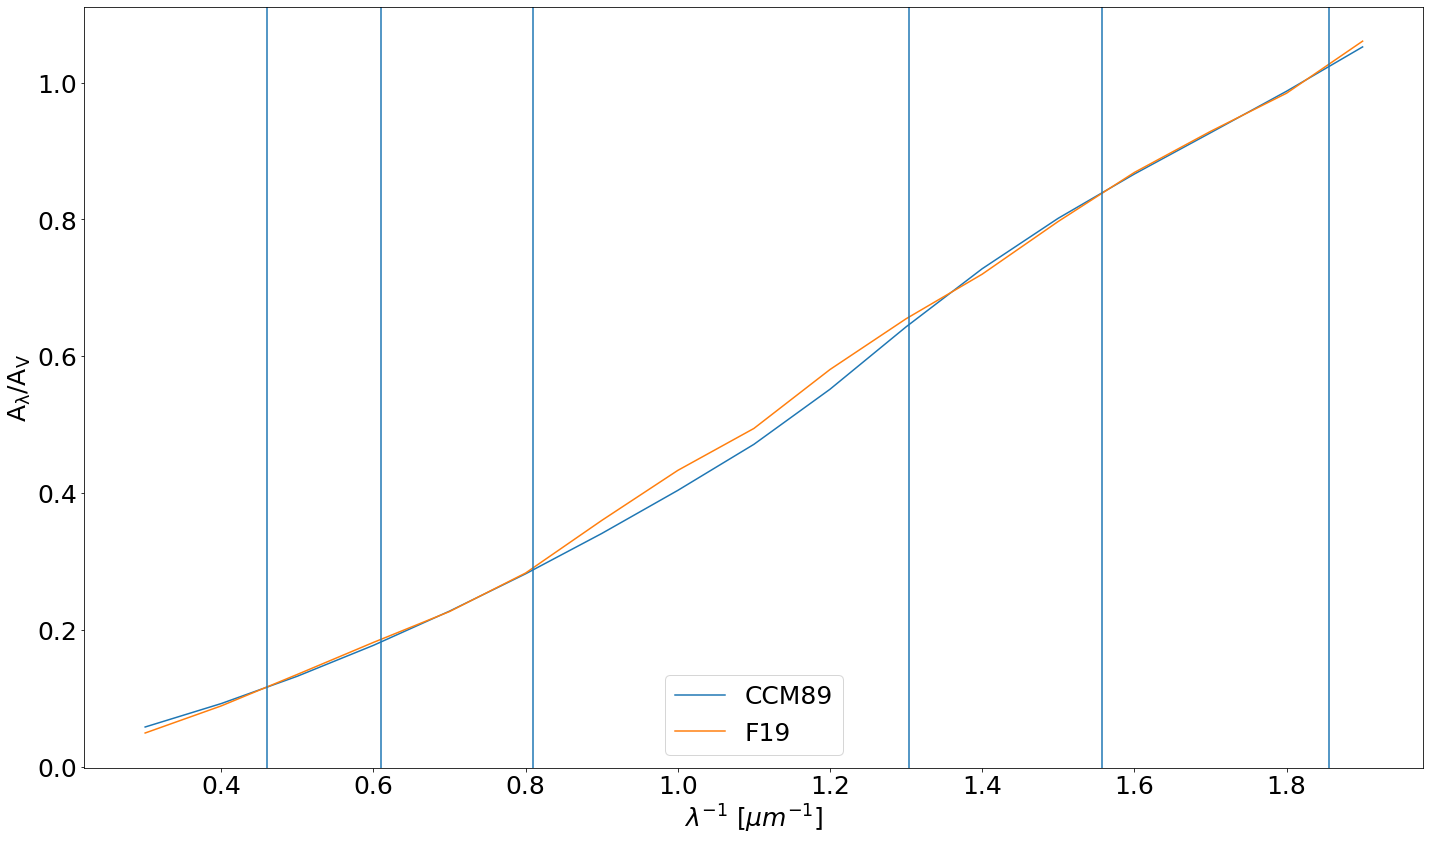

In [52]:
from dust_extinction.parameter_averages import CCM89, F19

fig, ax = plt.subplots(figsize=[24,14])


x = np.arange(0.3,2.0,0.1)/u.micron

ext_model = CCM89(Rv=3.1)
ax.plot(x,ext_model(x),label='CCM89')

ext_model = F19(Rv=3.1)
ax.plot(x,ext_model(x),label='F19')
    
for recip_wave in np.reciprocal(leff):
    plt.axvline(recip_wave)

ax.set_xlabel(r'$\lambda^{-1}$ [$\mu m^{-1}$]')
ax.set_ylabel(r'${\rm A_\lambda/A_V}$')

ax.legend(loc='best')
plt.show()

In [53]:
import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(np.reciprocal(wavelength*u.micron))/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(np.reciprocal(wavelength*u.micron))/ext_model(ref*u.micron)
    
    return ext_coeff